In [505]:
import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt
import uuid

In [545]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, MaxPooling2D, Input, Flatten, Dense, Lambda
import tensorflow as tf
from tensorflow.keras.metrics import Precision, Recall

In [340]:
## Avoid overconsumption of GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [11]:
import os
print(os.getcwd())

/Users/AshishR_T/Desktop/Timepass python projects/Deep Learning Model


In [16]:
POS_PATH = os.path.join('data', 'positive')
NEG_PATH = os.path.join('data', 'negative')
ANC_PATH = os.path.join('data', 'anchor')

In [19]:
print(ANC_PATH)

data/anchor


In [23]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()

    cv2.imshow('Image Collection', frame)

    if cv2.waitKey(1) & 0XFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

In [523]:
def random_jpeg_quality(image, min_quality=90, max_quality=100):
    # Generate a random quality value between min_quality and max_quality (inclusive)
    quality = np.random.randint(min_quality, max_quality + 1)
    # Encode the image (after scaling to [0,255] and casting to uint8)
    encoded = tf.io.encode_jpeg(tf.cast(image * 255, tf.uint8), quality=quality)
    # Decode it back to get the "compressed" image
    decoded = tf.io.decode_jpeg(encoded)
    # Convert back to float32 and scale to [0,1]
    decoded = tf.cast(decoded, tf.float32) / 255.0
    return decoded

In [524]:
def data_aug(img):
    data = []
    for i in range(9):
        # Create seeds for stateless operations
        seed_brightness = tf.constant([1, 2], dtype=tf.int32)
        seed_contrast   = tf.constant([1, 3], dtype=tf.int32)
        seed_flip       = tf.constant([np.random.randint(100), np.random.randint(100)], dtype=tf.int32)
        seed_saturation = tf.constant([np.random.randint(100), np.random.randint(100)], dtype=tf.int32)

        # Apply augmentations sequentially
        img_aug = tf.image.stateless_random_brightness(img, max_delta=0.02, seed=seed_brightness)
        img_aug = tf.image.stateless_random_contrast(img_aug, lower=0.6, upper=1, seed=seed_contrast)
        img_aug = tf.image.stateless_random_flip_left_right(img_aug, seed=seed_flip)
        # Use the custom JPEG quality function
        img_aug = random_jpeg_quality(img_aug, min_quality=90, max_quality=100)
        img_aug = tf.image.stateless_random_saturation(img_aug, lower=0.9, upper=1, seed=seed_saturation)
        
        data.append(img_aug)
    
    return data


In [528]:
OUTPUT_PATH = os.path.join(ANC_PATH, "augmented")
if not os.path.exists(OUTPUT_PATH):
    os.makedirs(OUTPUT_PATH)

# Process each file and write augmented images to OUTPUT_PATH
for file_name in os.listdir(ANC_PATH):
    img_path = os.path.join(ANC_PATH, file_name)
    
    # Skip directories
    if os.path.isdir(img_path):
        continue

    img = cv2.imread(img_path)
    # Check if the image was read successfully
    if img is None:
        print("Could not read image:", img_path)
        continue

    # Convert image to a TensorFlow tensor in float32 format and scale to [0, 1]
    img_tensor = tf.convert_to_tensor(img, dtype=tf.float32) / 255.0
    
    augmented_images = data_aug(img_tensor)  # your augmentation function
    
    for image in augmented_images:
        out_file = os.path.join(OUTPUT_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Convert tensor back to NumPy array, scale to [0, 255] and write the image
        cv2.imwrite(out_file, (image.numpy() * 255).astype('uint8'))

Could not read image: data/anchor/.DS_Store


In [24]:
# Loading and PreProcessing our Images

In [529]:
# Getting the Image Directories
anchor = tf.data.Dataset.list_files(os.path.join(ANC_PATH, '*.jpg')).take(5000)
positive = tf.data.Dataset.list_files(os.path.join(POS_PATH, '*.jpg')).take(5000)
negative = tf.data.Dataset.list_files(os.path.join(NEG_PATH, '*.jpg')).take(5000)

In [71]:
## Testing purposes!
dir_test = anchor.as_numpy_iterator()
dir_test.next()

b'data/anchor/5661dde2-f398-11ef-92dd-d2b34dc948be.jpg'

In [531]:
# PreProcessing - Scaling and Resizing
def preprocess (file_path):
    byte_img = tf.io.read_file(file_path)
    img = tf.io.decode_jpeg(byte_img)
    img = tf.image.resize(img, (105,105))
    img = img / 255.0
    return img

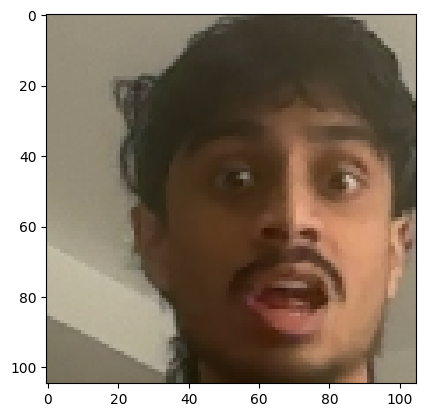

In [74]:
## Testing!
img = preprocess('data/anchor/5661dde2-f398-11ef-92dd-d2b34dc948be.jpg')
plt.imshow(img)
plt.show()

In [532]:
# Create Labelled Dataset
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [128]:
## Training purposes only!
samples = data.as_numpy_iterator()
for i in range(200):
    samples.next()
print(samples.next())

(b'data/anchor/9a403f9a-f398-11ef-92dd-d2b34dc948be.jpg', b'data/positive/1872577c-f399-11ef-92dd-d2b34dc948be.jpg', 1.0)


In [533]:
# Better function!
def preprocess_twin(input_img, validation_img, label):
    return (preprocess(input_img), preprocess(validation_img), label)

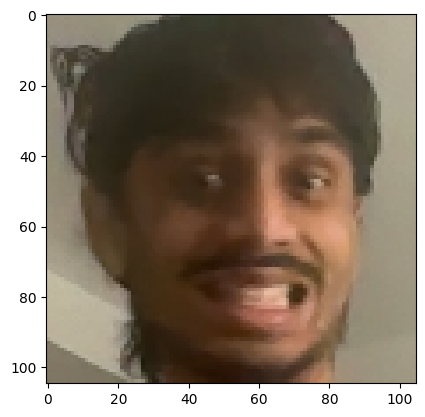

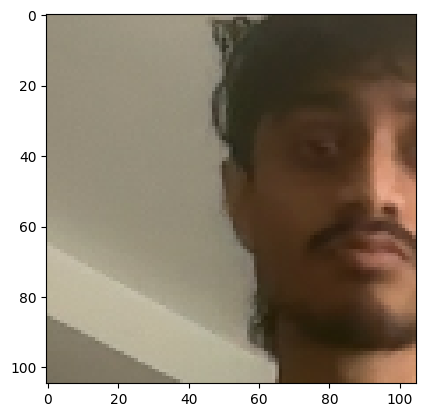

1.0

In [138]:
## Testing purposes!
test = preprocess_twin('data/positive/5829feb0-f399-11ef-92dd-d2b34dc948be.jpg', 'data/anchor/5f8c164e-f398-11ef-92dd-d2b34dc948be.jpg', 1.0)
plt.imshow(test[0])
plt.show()
plt.imshow(test[1])
plt.show()
test[2]

In [534]:
# Build dataloader pipeline
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=20000)

In [535]:
# Training partition
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16) # Divides the data into batches of 16 images each
train_data = train_data.prefetch(8) # Also could use AUTOTUNE method of tf so that it automatically decides the optimal number to prefetch

In [163]:
sample = train_data.as_numpy_iterator()
samp = sample.next()

In [171]:
samp[2]

array([0., 1., 1., 1., 0., 0., 0., 1., 0., 1., 1., 0., 1., 0., 1., 0.],
      dtype=float32)

In [536]:
# Testing partition
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

In [ ]:
# Model Engineering

In [537]:
# Build Embedding Layer
def make_embedding():

    # Copy these and run for better comprehension
    inp = Input(name = "input_image", shape = (105,105,3))
    c1 = Conv2D(64, (10,10), activation='relu')(inp)
    m1 = MaxPooling2D(64, (2,2), padding='same')(c1)

    c2 = Conv2D(128, (7,7), activation='relu')(m1)
    m2 = MaxPooling2D(64, (2,2), padding='same')(c2)

    c3 = Conv2D(128, (4,4), activation='relu')(m2)
    m3 = MaxPooling2D(64, (2,2), padding='same')(c3)

    c4 = Conv2D(256, (4,4), activation='relu')(m3)
    f1 = Flatten() (c4)
    d1 = Dense( 4096, activation='sigmoid')(f1)

    return Model(inputs = inp, outputs = d1, name = 'embedding')

In [538]:
embedding = make_embedding()
embedding.summary()

Model: "embedding"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)        │ (None, 105, 105, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_47 (Conv2D)              │ (None, 96, 96, 64)     │        19,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_38 (MaxPooling2D) │ (None, 48, 48, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_48 (Conv2D)              │ (None, 42, 42, 128)    │       401,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_39 (MaxPooling2D) │ (None, 21, 21, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_49 (Conv2D)              │ (None, 18, 18, 128)    │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_40 (MaxPooling2D) │ (None, 9, 9, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_50 (Conv2D)              │ (None, 6, 6, 256)      │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_8 (Flatten)             │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 4096)           │    37,752,832 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,960,448 (148.62 MB)

 Trainable params: 38,960,448 (148.62 MB)

 Non-trainable params: 0 (0.00 B)

In [539]:
# Building Distance Layer
class L1Dist(Layer):
    def __init__(self, **kwargs):
        super().__init__()

    def call(self, inputs):
        input_embedding, validation_embedding = inputs
        return tf.math.abs(input_embedding-validation_embedding)

In [540]:
# Making siamese model
def make_siamese_model():
    input_image = Input(name='input_img', shape=(105,105,3))
    validation_image = Input(name='validation_img', shape = (105,105,3))
    
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer([embedding(input_image), embedding(validation_image)])

    classifier = Dense(1, activation='sigmoid')(distances)
    return Model(inputs = [input_image, validation_image], outputs = classifier, name='SiameseNetwork')
     

In [541]:
siamese_model = make_siamese_model()
siamese_model.summary()

Model: "SiameseNetwork"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_img           │ (None, 105, 105,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ validation_img      │ (None, 105, 105,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 4096)      │ 38,960,448 │ input_img[0][0],  │
│ (Functional)        │                   │            │ validation_img[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ l1_dist_18 (L1Dist) │ (None, 4096)      │          0 │ embedding[0][0],  │
│                     │                   │            │ embedding[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_16 (Dense)    │ (None, 1)         │      4,097 │ l1_dist_18[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 38,964,545 (148.64 MB)

 Trainable params: 38,964,545 (148.64 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Training

In [542]:
# Setup Loss and Optimizer
binary_cross_loss = tf.losses.BinaryCrossentropy() # Loss Function
opt = tf.keras.optimizers.Adam(1e-4) # Optimizer Function

In [543]:
# Establish Checkpoints
checkpoint_dir = '/Users/AshishR_T/Desktop/Timepass python projects/Deep Learning Model/training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt = opt, siamese_model = siamese_model)

In [302]:
test_batch = train_data.as_numpy_iterator()
batch_1 = test_batch.next()

In [310]:
X = batch_1[:2]

In [318]:
y = batch_1[2]

In [324]:
yhat = siamese_model(X, training = True)
loss = binary_cross_loss(y, yhat)

In [326]:
loss

<tf.Tensor: shape=(), dtype=float32, numpy=0.69249845>

In [544]:
@tf.function
def train_step(batch):
    with tf.GradientTape() as tape:
        # Get anchor and positive/negative 
        X = batch[:2]
        # Get label
        y = batch[2]

        # Forward pass
        yhat = siamese_model(X, training = True) # y pred
        # Calculate loss
        loss = binary_cross_loss(y, yhat)

    # Calculate gradients
    grad = tape.gradient(loss, siamese_model.trainable_variables)

    # Calculate updated weights and apply to siamese model
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))

    return loss

In [546]:
# Build Traning Loop
def train(train_data, EPOCHS):
    for epoch in range(1, EPOCHS+1):
        print(f'\nEpoch {epoch}/{EPOCHS}')
        
        # Progress after each batch is completed! (len(train_data) - returns the number of batches in the training dataset)
        progress_bar = tf.keras.utils.Progbar(len(train_data))

        r = Recall()
        p = Precision()
        
        # Loop through each batch (becuz train_data = train_data.batch(16) --> so we loop through each batch)
        for idx, batch in enumerate(train_data):
            # Run train step here
            loss = train_step(batch)
            yhat = siamese_model.predict(batch[:2])
            r.update_state(batch[2], yhat)
            p.update_state(batch[2], yhat)
            
            progress_bar.update(idx+1)

        print(loss.numpy(), r.result().numpy(), p.result().numpy())

        # Save checkpoints
        if epoch % 10 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)       

In [547]:
train(train_data, 50)


Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 997ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 993ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 984ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 988ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 965ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 984ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 975ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 977ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 972ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 959ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 964ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 791ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 693ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 968ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 969ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 976ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 980ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 959ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 972ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 976ms/steptep
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 979ms/steptep
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 974ms/steptep
1/1 ━━━━━

2025-02-27 21:20:14.950539: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 982ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 969ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 990ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 991ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 993ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 992ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 962ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 961ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 977ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 993ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 991ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 975ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 969ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 988ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 977ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 967ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 963ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 680ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 983ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 983ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 982ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 895ms/steptep
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/stepstep
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 988ms/steptep
1/1 ━━━━━━━━━━━━━

2025-02-27 21:27:44.474835: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 991ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 967ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 981ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 987ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 961ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 960ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 966ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 967ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 955ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 967ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 959ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 981ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 926ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 961ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 967ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 981ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 990ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 970ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 961ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 957ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 991ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 966ms/steptep
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 990ms/steptep
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 968ms/steptep
1/1 ━━━━━━━━━━━━

KeyboardInterrupt: 

In [385]:
# Evaluate Model

In [418]:
# Get a batch of test data
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

In [432]:
# Make predictions
y_hat = siamese_model.predict([test_input, test_val])
y_hat

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step


array([[2.5553548e-10],
       [9.9999666e-01],
       [5.4360044e-08],
       [1.4586032e-08],
       [9.9999964e-01],
       [3.7928160e-07],
       [9.9997151e-01],
       [1.7881015e-10],
       [2.2476636e-10],
       [1.0000000e+00],
       [1.2940321e-11],
       [1.7428489e-07],
       [1.4905629e-07],
       [1.0000000e+00],
       [2.6515237e-10],
       [9.9998522e-01]], dtype=float32)

In [433]:
# Post processing the results
"""res = []
for prediction in y_hat:
    if prediction > 0.5:
        res.append(1)
    else:
        res.append(0)"""
# based on our model
[1 if prediction > 0.5 else 0 for prediction in y_hat]

[0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1]

In [434]:
# actual values - they seem to be matching - not a bad model!
y_true

array([0., 1., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 1.],
      dtype=float32)

In [435]:
# Creating a metric object (Recall)
r = Recall()

# Calculate the recall value
r.update_state(y_true, y_hat)

# Return Recall Result
r.result().numpy()

1.0

In [436]:
# Creating a metric object (Precision)
p = Precision()

# Calculate the precision value
p.update_state(y_true, y_hat)

# Return Precision Result
p.result().numpy()

1.0

In [549]:
r = Recall()
p = Precision()

for test_input, test_val, y_true in test_data.as_numpy_iterator():
    yhat = siamese_model.predict([test_input, test_val])
    r.update_state(y_true, yhat)
    p.update_state(y_true, yhat)

print(r.result().numpy(), p.result().numpy())

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━

2025-02-27 21:33:27.992030: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [551]:
# second commit after data augmentation!!

siamese_model.save('siameseModelV2.h5')

In [ ]:
# Saving Model

In [ ]:
siamese_model.save

In [438]:
# Save weights
siamese_model.save('siameseModel.h5')

In [441]:
# Reload model
model = tf.keras.models.load_model('siameseModel.h5',
                                    custom_objects={'L1Dist': L1Dist, 
                                    'BinaryCrossentropy':tf.losses.BinaryCrossentropy()})

In [442]:
# Make predictions with our reloaded model
model.predict([test_input, test_val])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


array([[2.5553548e-10],
       [9.9999666e-01],
       [5.4360044e-08],
       [1.4586032e-08],
       [9.9999964e-01],
       [3.7928160e-07],
       [9.9997151e-01],
       [1.7881015e-10],
       [2.2476636e-10],
       [1.0000000e+00],
       [1.2940321e-11],
       [1.7428489e-07],
       [1.4905629e-07],
       [1.0000000e+00],
       [2.6515237e-10],
       [9.9998522e-01]], dtype=float32)

In [444]:
model.summary()

Model: "SiameseNetwork"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_img           │ (None, 105, 105,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ validation_img      │ (None, 105, 105,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 4096)      │ 38,960,448 │ input_img[0][0],  │
│ (Functional)        │                   │            │ validation_img[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ l1_dist_17 (L1Dist) │ (None, 4096)      │          0 │ embedding[0][0],  │
│                     │                   │            │ embedding[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_14 (Dense)    │ (None, 1)         │      4,097 │ l1_dist_17[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 38,964,545 (148.64 MB)

 Trainable params: 38,964,545 (148.64 MB)

 Non-trainable params: 0 (0.00 B)

In [445]:
# Real Time Test

In [474]:
# Verification function
def verify(model, detection_threshold, verification_threshold):
    # Build results array
    results = []
    # Looping through the verification images in the application_data folder
    for image in os.listdir(os.path.join('application_data', 'verification_images')):
        if not image.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp')):  # Ignore non-images
            continue
        # Assigning input_img input_image.jpg
        input_img = preprocess(os.path.join('application_data', 'input_image', 'input_image.jpg'))
        # Preprocessing each image and assigning it to validation_img 
        validation_img = preprocess(os.path.join('application_data', 'verification_images', image))

        # Making predictions
        result = model.predict(list(np.expand_dims([input_img, validation_img], axis=1)))
        results.append(result)

    # Detection Threshold: Metric above which a prediction is considered positive
    detection = np.sum(np.array(results) > detection_threshold)

    # Verification Threshold: Proportion of positive predictions / total positive samples
    verification = detection / len(os.listdir(os.path.join('application_data', 'verification_images')))
    verified = verification > verification_threshold

    return results, verified

In [502]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    
    if not ret or frame is None:
        print("Error: Failed to capture frame.")
        continue  # Skip this loop iteration and try again

    # Move the crop up
    frame = frame[250:500, 600:850, :]  # Ensure correct crop

    cv2.imshow('Verification', frame)

    # Verification trigger
    if cv2.waitKey(10) & 0xFF == ord('v'):
        cv2.imwrite(os.path.join('application_data', 'input_image', 'input_image.jpg'), frame)
        results, verified = verify(model, 0.9, 0.5)
        print(verified)
        
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break

cap.release() 
cv2.destroyAllWindows()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━